In [17]:
WORKING_DIR = "/home/xavier/Documents/DAE_project"

# Collect model and LS3934 selected frames

In [18]:
import pandas as pd
import os
import shutil
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import dnnlib
import legacy
import torch
from training.networks_stylegan2 import SynthesisLayer


def resize_crop(img_name, resize_by=1., resolution=512, brightness_norm=True, brightness_mean=107):
    if isinstance(img_name, str):
        img = cv2.imread(img_name, cv2.IMREAD_UNCHANGED)
    else:
        img = img_name
    if img.dtype != np.uint8:
        img = np.uint8(img / 256)
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_shape = img.shape
    resize_shape = np.array([img_shape[1] * resize_by, img_shape[0] * resize_by], dtype=int)
    if resize_by != 1:
        img = cv2.resize(img, resize_shape, cv2.INTER_LANCZOS4)
    img = img[(resize_shape[1] - resolution) // 2:(resize_shape[1] + resolution) // 2,
    (resize_shape[0] - resolution) // 2:(resize_shape[0] + resolution) // 2]
    if brightness_norm:
        obj_v = np.mean(img)
        value = brightness_mean - obj_v
        img = cv2.add(img, value)
    return img


MODEL_DIR = f"{WORKING_DIR}/models/network-snapshot-003024-patched.pkl"

os.environ['CC'] = "/usr/bin/gcc-9"
os.environ['CXX'] = "/usr/bin/g++-9"
device = torch.device('cuda')


def reset_noise_const(G, seed):
    torch.manual_seed(seed)

    for block in G.synthesis.children():
        for layer in block.children():
            if isinstance(layer, SynthesisLayer):
                resolution = layer.resolution

                with torch.no_grad():
                    layer.noise_const.copy_(torch.randn([resolution, resolution]))


with dnnlib.util.open_url(MODEL_DIR) as fp:
    models = legacy.load_network_pkl(fp)
    E = models['E_ema'].to(device)
    G = models['G_ema'].to(device)  # type: ignore

In [19]:
def extract_frames(video_path, frame_numbers):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_path}")
        return
    ans = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for frame_number in frame_numbers:
        if frame_number >= total_frames:
            break
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()
        if ret:
            ans.append(frame)
        else:
            print(f"Error: Unable to read frame {frame_number} from {video_path}")

    cap.release()
    return ans


selected_movies = [f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_5/LS3934 2N 022014_565.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_5/LS3934 2N 022814_573.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_5/LS3934 2N 030614_615.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_6/LS3934 60N 030214_538.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_6/LS3934 60N 030414_543.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_6/LS3934 60N 032214_540.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_7/LS3934 .2N 013114_532.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_7/LS3934 0.2N 030814_509.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_8/LS3934 0.6N 031214_596.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_8/LS3934 0.6N 031414_567.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_8/LS3934 0.6N 031614_625.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_0/LS3934 6N 021014_786.avi",
                   # f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_0/LS3934 6N 021314_800.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_0/LS3934 6N 031814_552.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_1/LS3934 010414_578.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_1/LS3934 010614_563.avi",
                   # f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_1/LS3934 012314_800.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_2/LS3934 2000N 022214_579.avi",
                   # f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_3/LS3934 200N 020314_800.avi",
                   # f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_3/LS3934 200N 020714_601.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_3/LS3934 200N 022414_588.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_3/LS3934 200N 022614_547.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_4/LS3934 20N 011314_512.avi",
                   # f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_4/LS3934 20N 020514_595.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_4/LS3934 20N 031014_582.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_4/LS3934 20N 032014_551.avi"]

frame_numbers = list(range(0, 600, 60))
images = []
zs = []
reset_noise_const(G, 4)
for selected_movie in selected_movies:
    selected_frames = extract_frames(selected_movie, frame_numbers)
    for frame in selected_frames:
        image = resize_crop(frame, resize_by=23 / 20)
        image = torch.Tensor(np.array(image)).to(device).to(torch.float32) / 127.5 - 1
        image = image[None, None, :, :]
        z, _ = E.mu_var(image, None)
        zs.append(z.cpu().numpy())

zs = np.concatenate(zs, axis=0)

# PCA

In [20]:
from sklearn.decomposition import PCA


def extract_all_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_path}")
        return []

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    cap.release()
    return frames


pca = PCA(n_components=2)
zs_new = pca.fit_transform(zs)

encoded_movies = {0: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_1/LS3934 010614_563.avi",
                  6: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_0/LS3934 6N 031814_552.avi",
                  #LS3934 6N 021014_786.avi",
                  60: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_6/LS3934 60N 030414_543.avi"
                  }
# encoded_movies = {0: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_1/LS3934 010614_563.avi",
#                   2: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_5/LS3934 2N 022814_573.avi",
#                   20: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_4/LS3934 20N 031014_582.avi",
#                   200: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_3/LS3934 200N 022414_588.avi",
#                   2000: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_2/LS3934 2000N 022214_579.avi"
#                   }
# encoded_movies = {0: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_1/LS3934 010614_563.avi",
#                   2: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_5/LS3934 2N 022814_573.avi",
#                   6: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_0/LS3934 6N 021014_786.avi",
#                   20: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_4/LS3934 20N 031014_582.avi",
#                   60: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_6/LS3934 60N 030414_543.avi",
#                   200: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_3/LS3934 200N 022414_588.avi",
#                   2000: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_2/LS3934 2000N 022214_579.avi"
#                   }
traj = {}
for label, movie_path in encoded_movies.items():
    print(movie_path)
    selected_frames = extract_all_frames(movie_path)
    while len(selected_frames) % 4 != 0:
        selected_frames.pop()
    selected_frames = selected_frames[:540]
    batch_size = 40
    current_traj = []
    for i in range(0, len(selected_frames), batch_size):
        batch_frames = selected_frames[i:i + batch_size]
        # print(len(batch_frames))
        if batch_frames == []:
            continue
        # Preprocess batch of frames
        images = [resize_crop(frame, resize_by=23 / 20) for frame in batch_frames]
        images = torch.Tensor(np.array(images)).to(torch.float32) / 127.5 - 1
        images = images[:, None, :, :]
        # Encode using a model (E.mu_var is assumed to be available)
        images = images.to(device)
        z, _ = E.mu_var(images, None)
        current_traj.append(z.cpu().numpy())
    traj[label] = np.concatenate(current_traj, axis=0)


/home/xavier/Documents/DAE_project/dataset/Larry/LS3934/LS3934_1/LS3934 010614_563.avi
/home/xavier/Documents/DAE_project/dataset/Larry/LS3934/LS3934_0/LS3934 6N 031814_552.avi
/home/xavier/Documents/DAE_project/dataset/Larry/LS3934/LS3934_6/LS3934 60N 030414_543.avi


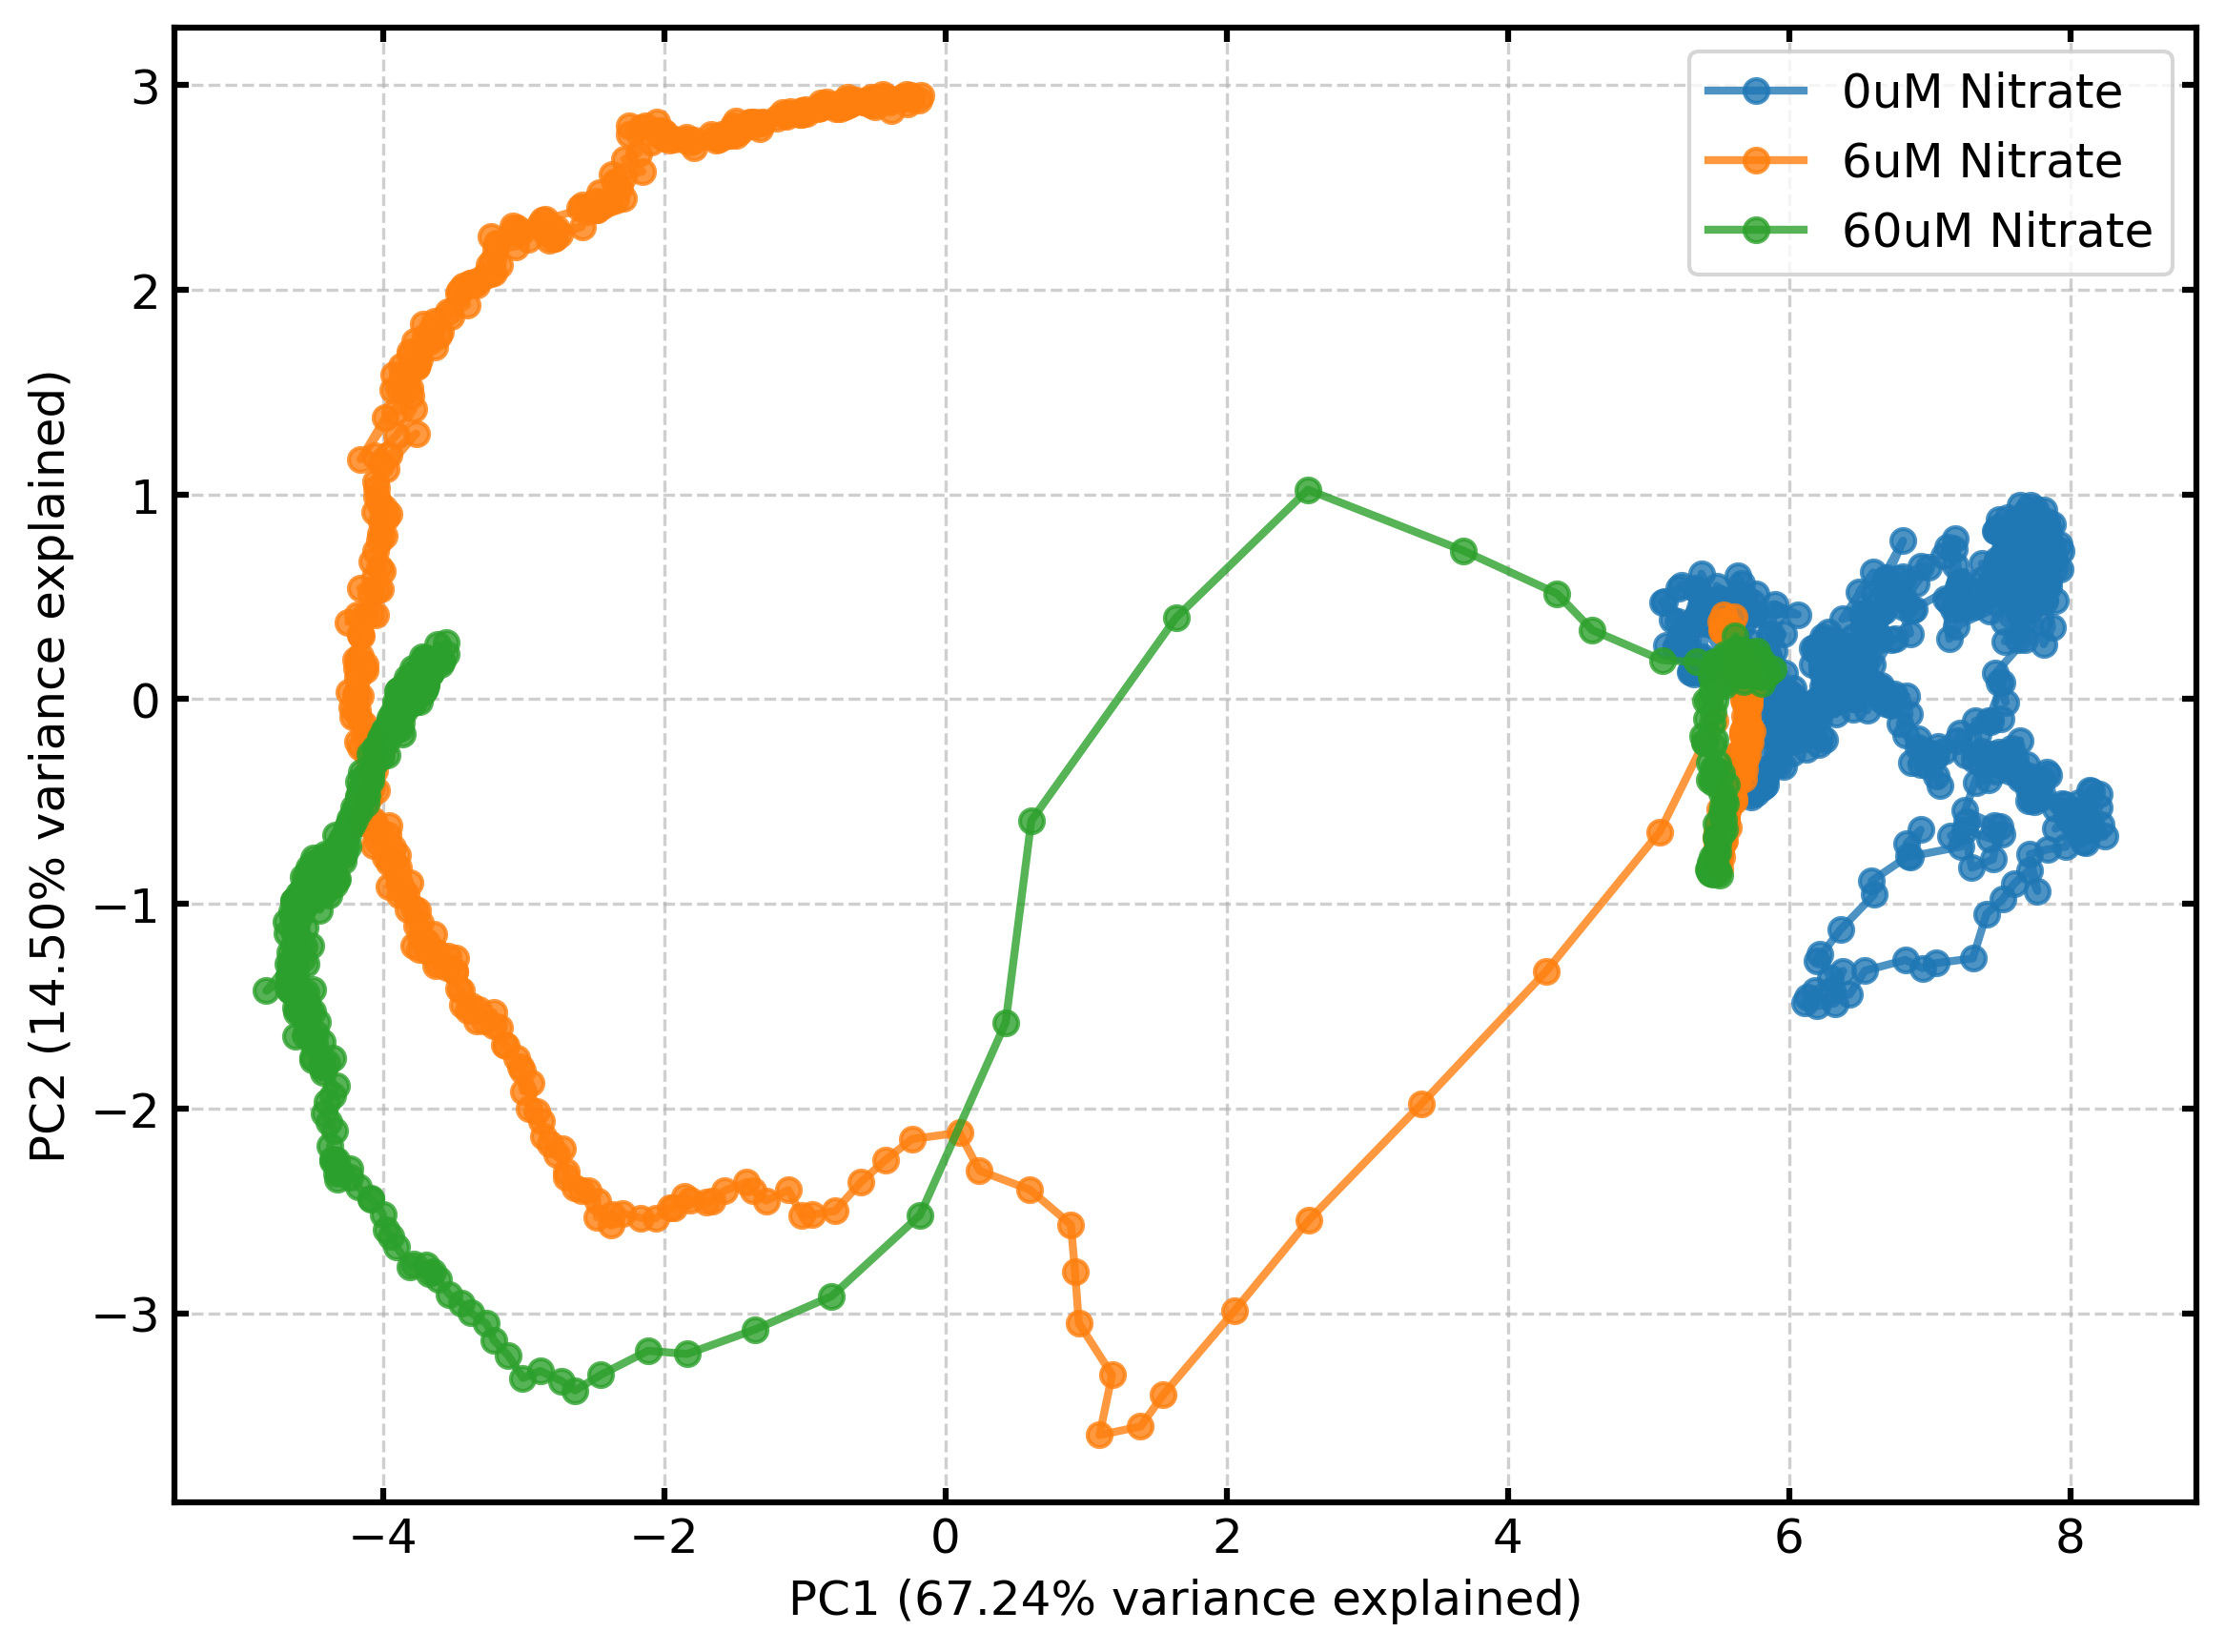

In [21]:

import matplotlib as mpl

# --- Matplotlib Configuration for PNAS-Style Publication ---
# This setup ensures fonts are embedded correctly and the style is professional.
plt.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['text.usetex'] = False

plt.rcParams.update({
    'font.size': 14,
    'font.family': 'Arial',
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.figsize': (8, 6),  # Standard 4:3 aspect ratio
    'axes.linewidth': 1.5,
    'lines.linewidth': 2.0,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
})
highlight_frames = [0, 300, 540]
highlight_markers = {0: 'o', 300: 's', 540: '^'}
# colors = ['red', 'green', 'blue']
for label in traj.keys():
    pca_traj = pca.transform(traj[label])
    plt.plot(pca_traj[:, 0], pca_traj[:, 1], label=f"{label}uM Nitrate", marker='o',
             linestyle='-', alpha=0.8)

# Add explained variance to the axis labels
explained_variance = pca.explained_variance_ratio_ * 100

# plt.title("Trajectories of Movies in PCA Space", fontsize=16)
plt.xlabel(f"PC1 ({explained_variance[0]:.2f}% variance explained)", fontsize=12)
plt.ylabel(f"PC2 ({explained_variance[1]:.2f}% variance explained)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
OUT_DIR = f"{WORKING_DIR}/images/figure3/Shimkets_Nitrate/"
os.makedirs(OUT_DIR, exist_ok=True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, '6_1.pdf'), format='pdf')

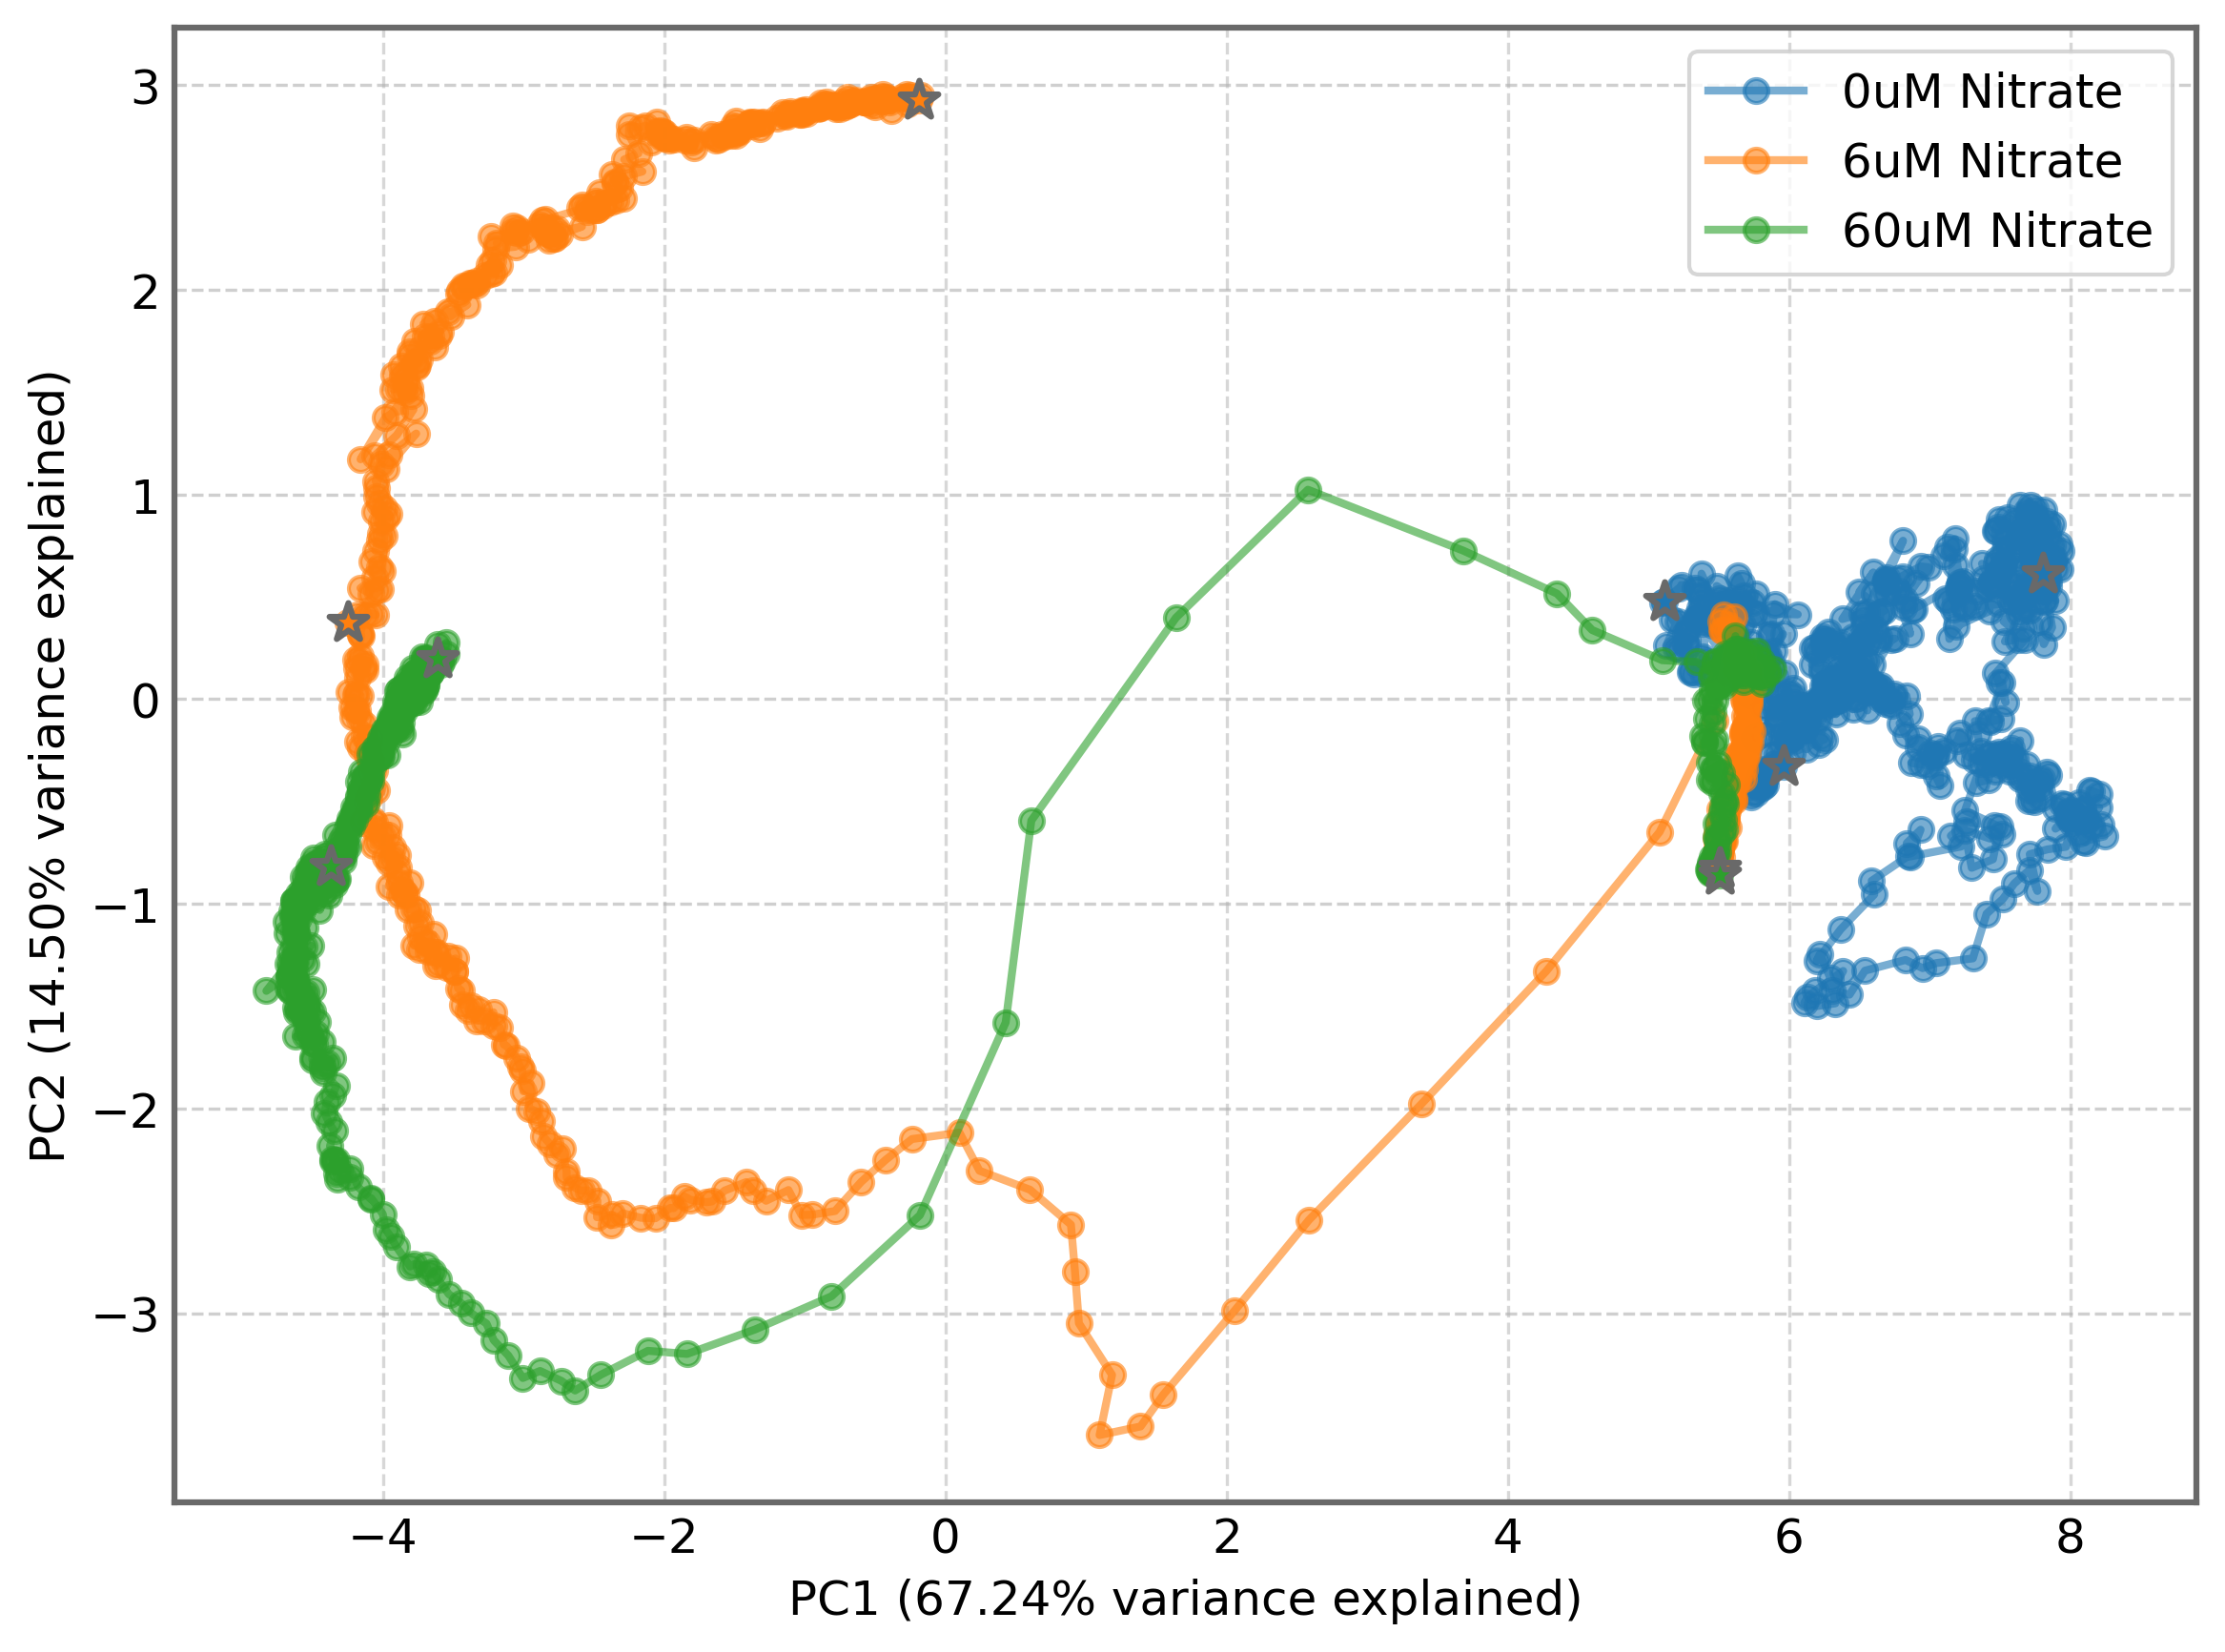

In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.decomposition import PCA

# --- Matplotlib Configuration for PNAS-Style Publication ---
# This setup ensures fonts are embedded correctly and the style is professional.
plt.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['text.usetex'] = False

plt.rcParams.update({
    'font.size': 14,
    'font.family': 'Arial',
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.figsize': (8, 6),  # Standard 4:3 aspect ratio
    'axes.linewidth': 1.5,
    'lines.linewidth': 2.0,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
})


def style_ax(ax):
    """
    Unified styling:
    - Gray borders
    - Dashed grid behind all artists, alpha=0.5
    - No tick marks ("little spikes")
    - Transparent background
    """
    # ax.set_facecolor('none')
    # Gray frame
    for spine in ax.spines.values():
        spine.set_edgecolor('dimgray')

    # Grid under everything
    ax.set_axisbelow(True)
    ax.grid(True, axis='x', linestyle='--', alpha=0.5, zorder=0)
    # Remove tick spikes
    ax.tick_params(axis='both', which='both', length=0)


# --- Plotting Section ---
fig, ax = plt.subplots(figsize=(8, 6))

# Define frames and markers for highlighting
highlight_frames = [0, 300, -1]
highlight_markers = {0: '*', 300: '*', -1: '*'}

# Loop through each trajectory to plot
for label in traj.keys():
    # Transform the trajectory data into PCA space
    pca_traj = pca.transform(traj[label])

    # Plot the full trajectory line
    # We capture the line object to get its color for the markers
    line, = ax.plot(pca_traj[:, 0], pca_traj[:, 1], label=f"{label}uM Nitrate",
                    linestyle='-', marker="o", alpha=0.6)

    # Now, highlight the specific points on top of the line
    for frame_idx in highlight_frames:
        if frame_idx < len(pca_traj):  # Ensure the index is within bounds
            ax.scatter(
                pca_traj[frame_idx, 0],  # x-coordinate of the point
                pca_traj[frame_idx, 1],  # y-coordinate of the point
                marker=highlight_markers[frame_idx],  # Use the specific marker
                c=[line.get_color()],  # Match the facecolor to the line color
                edgecolor='dimgray',  # Set the edge color
                linewidth=1.5,  # Make the edge visible
                s=100,  # Set a larger size for visibility
                zorder=5  # Ensure markers are drawn on top of lines
            )

# Add explained variance to the axis labels
explained_variance = pca.explained_variance_ratio_ * 100

# Set plot labels, legend, and grid
ax.set_xlabel(f"PC1 ({explained_variance[0]:.2f}% variance explained)", fontsize=12)
ax.set_ylabel(f"PC2 ({explained_variance[1]:.2f}% variance explained)", fontsize=12)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
style_ax(ax)

# --- Save the Figure ---.
OUT_DIR = f"{WORKING_DIR}/images/figure3/Shimkets_Nitrate/"
os.makedirs(OUT_DIR, exist_ok=True)

# Adjust layout and save the plot as a PDF
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, '6_1.pdf'), format='pdf')

# Display the plot
plt.show()


In [13]:
import seaborn as sns
import plotly.express as px
# Prepare a DataFrame for Seaborn
import pandas as pd

data = []
for label, points in traj.items():
    pca_traj = pca.transform(points)
    for i, (x, y) in enumerate(pca_traj):
        data.append({"Movie": label, "Index": i, "PCA1": x, "PCA2": y})
df = pd.DataFrame(data)

fig = px.scatter(
    df,
    x="PCA1",
    y="PCA2",
    color="Movie",
    hover_data=["Movie", "Index", "PCA1", "PCA2"],
    title="Trajectories of Movies in PCA Space",
    labels={
        "PCA1": f"PCA Component 1 ({pca.explained_variance_ratio_[0] * 100:.2f}% variance explained)",
        "PCA2": f"PCA Component 2 ({pca.explained_variance_ratio_[1] * 100:.2f}% variance explained)",
    },
)

# Display the interactive plot
fig.show()

# Get selected frames

In [14]:
check_frames = [0, 300, 540]
selected_dir = os.path.join(OUT_DIR, '6')
os.makedirs(selected_dir, exist_ok=True)
for label, movie_path in encoded_movies.items():
    print(movie_path)
    img_name = movie_path.split("/")[-1].split(".")[0]
    selected_frames = extract_frames(movie_path, check_frames)
    for frame, idx in zip(selected_frames, check_frames):
        image = resize_crop(frame, resize_by=23 / 20)
        cv2.imwrite(os.path.join(selected_dir, f"{img_name}_{label}_{idx}.png"), image)

        image = torch.Tensor(image).to(device).to(torch.float32) / 127.5 - 1
        image = image[None, None, :, :]
        z, _ = E.mu_var(image, None)
        synth_image = G(z, None, noise_mode='const')
        synth_image = (synth_image + 1) * 127.5
        synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().numpy()[:, :, :, 0]
        cv2.imwrite(os.path.join(selected_dir, f"{img_name}_{label}_{idx}_recon.png"), synth_image[0])


/home/xavier/Documents/DAE_project/dataset/Larry/LS3934/LS3934_1/LS3934 010614_563.avi
/home/xavier/Documents/DAE_project/dataset/Larry/LS3934/LS3934_0/LS3934 6N 031814_552.avi
/home/xavier/Documents/DAE_project/dataset/Larry/LS3934/LS3934_6/LS3934 60N 030414_543.avi


# Reconstruct movies

In [29]:
# === Trajectory and Reconstruction Video Generator ===

import os
import cv2
import numpy as np
import torch
import dnnlib
import legacy  # Assuming from StyleGAN/PGAN repo
import matplotlib as mpl
import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA # 1. Removed PCA import, assuming 'pca' object is pre-fitted
from tqdm import tqdm  # Add a progress bar, as this will be slow

# --- Working Directory (Assume 'WORKING_DIR' is defined in the environment) ---
# If not in a notebook environment, uncomment and set this
# WORKING_DIR = "/home/xavier/Documents/DAE_project"

# --- 1. Environment, Model, and Parameter Setup ---
os.environ['CC'] = "/usr/bin/gcc-9"
os.environ['CXX'] = "/usr/bin/g++-9"

network_pkl = f"{WORKING_DIR}/models/network-snapshot-003024-patched.pkl"
RECONSTRUCTION_SEED = 42
BATCH_SIZE = 16  # Number of frames to process at once, adjust based on your GPU VRAM
NUM_FRAMES = 540  # Truncate all videos to this uniform frame length
VIDEO_FPS = 20  # Output video framerate

# Output video parameters
IMG_SIZE = 256  # Size of each small image in the final video
BORDER_SIZE = 8  # 2. Added: Pixel width for the colored border
TITLE_WIDTH = 70  # 2. Added: Pixel width for row titles ("Original", "Reconstruction")
TEXT_ROW_HEIGHT = 60  # 1. Added: Space at the top for colored labels
OUT_DIR = f"{WORKING_DIR}/images/figure3/Shimkets_Nitrate/"
VIDEO_SAVE_PATH = os.path.join(OUT_DIR, 'trajectory_comparison_video.mp4')

# Movies to process
encoded_movies = {
    0: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_1/LS3934 010614_563.avi",
    6: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_0/LS3934 6N 031814_552.avi",
    60: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_6/LS3934 60N 030414_543.avi"
}
NUM_VIDEOS = len(encoded_movies)


# --- 2. Helper Functions ---

def reset_noise_const(G, seed):
    """Resets the noise constants in the synthesis network with a fixed seed."""
    torch.manual_seed(seed)
    for block in G.synthesis.children():
        for layer in block.children():
            if layer.__class__.__name__ == "SynthesisLayer":
                resolution = layer.resolution
                with torch.no_grad():
                    layer.noise_const.copy_(torch.randn([resolution, resolution]))


def extract_all_frames(video_path):
    """Extracts all frames from a video file."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_path}")
        return []
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames


def process_frame(img, resize_by=1.0, resolution=512, brightness_norm=True, brightness_mean=107):
    """
    Processes a single video frame (Numpy array).
    Resizes, crops, normalizes brightness, and ensures grayscale.
    """
    if img is None:
        raise ValueError("Input frame is None")

    # 1. Ensure grayscale (required by the model)
    if img.ndim == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    elif img.ndim == 3 and img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)

    if img.dtype != np.uint8:
        img = (img / img.max() * 255).astype(np.uint8)

    # 2. Resize
    original_shape = img.shape  # (height, width)
    resized_shape = (int(original_shape[1] * resize_by), int(original_shape[0] * resize_by))  # (width, height)

    if resize_by != 1.0:
        img = cv2.resize(img, resized_shape, interpolation=cv2.INTER_LANCZOS4)

    # 3. Center Crop
    center_crop = img[
        (resized_shape[1] - resolution) // 2:(resized_shape[1] + resolution) // 2,
        (resized_shape[0] - resolution) // 2:(resized_shape[0] + resolution) // 2
    ]

    # 4. Brightness Normalization
    if brightness_norm:
        current_mean = np.mean(center_crop)
        delta = brightness_mean - current_mean
        center_crop = np.clip(cv2.add(center_crop, delta), 0, 255).astype(np.uint8)

    return center_crop  # Returns 512x512 grayscale image


def convert_plot_to_image(fig):
    """Converts a Matplotlib figure to an OpenCV BGR image."""
    fig.canvas.draw()
    plot_img_buf = fig.canvas.buffer_rgba()
    plot_img = np.frombuffer(plot_img_buf, dtype=np.uint8).reshape(fig.canvas.get_width_height()[::-1] + (4,))
    plot_img_bgr = cv2.cvtColor(plot_img, cv2.COLOR_RGBA2BGR)
    return plot_img_bgr


# --- 3. Load Model ---
print("Loading reconstruction model...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
try:
    with dnnlib.util.open_url(network_pkl) as fp:
        models = legacy.load_network_pkl(fp)
        E = models['E_ema'].to(device)
        G = models['G_ema'].to(device)
    reset_noise_const(G, RECONSTRUCTION_SEED)
    print(f"Model {network_pkl} loaded to {device}.")
except Exception as e:
    print(f"FATAL: Could not load model. Error: {e}")
    exit()

# --- 4. Matplotlib Style Configuration ---
plt.style.use('default')
mpl.rcParams.update({
    'font.size': 10, 'font.family': 'Arial', 'axes.labelsize': 12,
    'axes.titlesize': 14, 'legend.fontsize': 10, 'xtick.labelsize': 10,
    'ytick.labelsize': 10, 'figure.dpi': 150, 'savefig.dpi': 150,
    'axes.linewidth': 1, 'lines.linewidth': 1.5, 'xtick.major.width': 1,
    'ytick.major.width': 1, 'xtick.direction': 'in', 'ytick.direction': 'in',
    'xtick.top': True, 'ytick.right': True, 'pdf.fonttype': 42, 'ps.fonttype': 42,
})

# --- 5. Data Processing: Extract, Encode, and Reconstruct ---

video_data = {}  # Stores all frames, z-vectors, and reconstructions
# all_latents_list = [] # 1. Removed: No longer needed to fit PCA

print(f"Processing {NUM_VIDEOS} videos to extract {NUM_FRAMES} frames each...")

for label, movie_path in encoded_movies.items():
    print(f"  Processing: {movie_path} (Label: {label}uM)")

    # Extract frames
    raw_frames = extract_all_frames(movie_path)
    if len(raw_frames) < NUM_FRAMES:
        print(f"    Warning: Video shorter than {NUM_FRAMES} frames. Found {len(raw_frames)}. Skipping.")
        continue

    selected_frames = raw_frames[:NUM_FRAMES]

    video_data[label] = {
        'originals': [],
        'latents': [],
        'recons': []
    }

    # Process in batches
    for i in tqdm(range(0, NUM_FRAMES, BATCH_SIZE), desc=f"    Encoding {label}uM"):
        batch_raw_frames = selected_frames[i:i + BATCH_SIZE]
        if not batch_raw_frames:
            continue

        # 5a. Preprocess original frames (Numpy)
        # Note: resize_by value comes from your original script
        images_orig_np = [process_frame(frame, resize_by=23 / 20) for frame in batch_raw_frames]
        video_data[label]['originals'].extend(images_orig_np)

        # 5b. Prepare model input (Tensor)
        images_tensor = torch.Tensor(np.array(images_orig_np)).to(device).to(torch.float32) / 127.5 - 1
        images_tensor = images_tensor.unsqueeze(1)  # (B, 1, 512, 512)

        # 5c. Encode (get z)
        with torch.no_grad():
            z, _ = E.mu_var(images_tensor, None)

        video_data[label]['latents'].append(z.cpu().numpy())

        # 5d. Reconstruct (get recon)
        with torch.no_grad():
            ws = G.mapping(z, None)
            synth_image_tensor = G.synthesis(ws, noise_mode='const')

        # 5e. Post-process reconstructed images
        synth_image_tensor = (synth_image_tensor + 1) * 127.5
        # Assume grayscale output [B, 1, H, W] -> [B, H, W]
        synth_images_np = synth_image_tensor.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().numpy()[:, :, :, 0]
        video_data[label]['recons'].extend(synth_images_np)

    # Consolidate data
    video_data[label]['originals'] = video_data[label]['originals']  # Already a list
    video_data[label]['latents'] = np.concatenate(video_data[label]['latents'], axis=0)
    video_data[label]['recons'] = video_data[label]['recons']  # Already a list

    # 1. Removed: all_latents_list.append(video_data[label]['latents'])

print("All frames processed.")

# --- 6. PCA Transform (Assuming Pre-fitted PCA) ---
print("Transforming latent vectors using pre-fitted PCA model...")
# 1. Assume 'pca' object is pre-fitted and available in the scope.
for label in video_data.keys():
    video_data[label]['pca_traj'] = pca.transform(video_data[label]['latents'])

explained_variance = pca.explained_variance_ratio_ * 100
print(f"PCA transform complete. PC1: {explained_variance[0]:.2f}%, PC2: {explained_variance[1]:.2f}%")

# --- 7. Prepare Video Layout and Plot ---

# Layout calculations
GRID_W_IMAGES = NUM_VIDEOS * IMG_SIZE
GRID_W = GRID_W_IMAGES + TITLE_WIDTH  # 2. Added title width
GRID_H = (2 * IMG_SIZE) + TEXT_ROW_HEIGHT  # 1. Added space for top text labels
PLOT_W = GRID_W  # 2. Plot width matches total grid width
PLOT_H = int(PLOT_W / (4 / 3))  # 4:3 aspect ratio for plot
OUT_W = GRID_W
OUT_H = PLOT_H + GRID_H

# Colors
labels_sorted = sorted(video_data.keys())
# 2. Use Matplotlib's default C0, C1, C2... colors (from 'tab10' colormap)
default_colors_rgba = [plt.cm.get_cmap('tab10')(i) for i in range(NUM_VIDEOS)]
color_map = {label: default_colors_rgba[i] for i, label in enumerate(labels_sorted)}

# Get static plot limits
all_pca_traj = np.concatenate([video_data[label]['pca_traj'] for label in labels_sorted], axis=0)
x_min, x_max = all_pca_traj[:, 0].min(), all_pca_traj[:, 0].max()
y_min, y_max = all_pca_traj[:, 1].min(), all_pca_traj[:, 1].max()
x_pad = (x_max - x_min) * 0.05
y_pad = (y_max - y_min) * 0.05

# Create base plot
fig, ax = plt.subplots(figsize=(PLOT_W / 100, PLOT_H / 100))  # Matplotlib figsize is in inches
ax.set_xlim(x_min - x_pad, x_max + x_pad)
ax.set_ylim(y_min - y_pad, y_max + y_pad)
ax.set_xlabel(f"PC1 ({explained_variance[0]:.2f}% variance)")
ax.set_ylabel(f"PC2 ({explained_variance[1]:.2f}% variance)")
ax.set_title("PCA Trajectories")

# Draw faint backgrounds for all trajectories
# legend_handles = [] # 3. Removed legend handle creation
for label in labels_sorted:
    data = video_data[label]
    traj = data['pca_traj']
    # Draw background
    ax.plot(traj[:, 0], traj[:, 1], color=color_map[label], alpha=0.2, linestyle='--')
    # Create legend handle
    # handle = mpl.lines.Line2D([0], [0], color=color_map[label], lw=2, label=f"{label}uM Nitrate") # 3. Removed
    # legend_handles.append(handle) # 3. Removed

# ax.legend(handles=legend_handles, loc='upper right')  # 3. Removed legend from plot
fig.tight_layout()

# --- 8. Generate Video ---
print(f"Creating composite video at {VIDEO_SAVE_PATH}...")
os.makedirs(OUT_DIR, exist_ok=True)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(VIDEO_SAVE_PATH, fourcc, VIDEO_FPS, (OUT_W, OUT_H))

if not video_writer.isOpened():
    print(f"Error: Could not open VideoWriter for {VIDEO_SAVE_PATH}")
    exit()

# 2. Pre-calculate inner image size for borders
INNER_IMG_SIZE = IMG_SIZE - (2 * BORDER_SIZE)

# Animation loop
for i in tqdm(range(NUM_FRAMES), desc="Generating video frames"):

    # 8a. Draw dynamic plot elements
    plot_artists = []
    for label in labels_sorted:
        traj_so_far = video_data[label]['pca_traj'][0:i + 1]
        color = color_map[label]

        # Draw active trajectory
        line, = ax.plot(traj_so_far[:, 0], traj_so_far[:, 1], color=color, linewidth=2)
        # Draw head
        head, = ax.plot(traj_so_far[-1, 0], traj_so_far[-1, 1], marker='o', color=color, markersize=8)

        plot_artists.extend([line, head])

    # Frame counter
    frame_text = ax.text(0.01, 0.01, f'Frame: {i}/{NUM_FRAMES}', transform=ax.transAxes, fontsize=10,
                         bbox=dict(facecolor='white', alpha=0.5, pad=0.1))
    plot_artists.append(frame_text)

    # Convert plot to image
    plot_img_bgr = convert_plot_to_image(fig)
    plot_img_resized = cv2.resize(plot_img_bgr, (PLOT_W, PLOT_H))

    # 8b. Create image grid
    # 2. Changed background to white
    composite_grid = np.full((GRID_H, GRID_W, 3), 255, dtype=np.uint8)  # White background

    # 4. Draw colored text labels at the top of the grid
    text_font_scale = 1.0
    text_font_thickness = 2
    # Center text vertically in the top row
    text_y_pos = (TEXT_ROW_HEIGHT - 20) // 2 + 20  # Adjusted for better centering

    for idx, label in enumerate(labels_sorted):
        text = f"{label}uM Nitrate"
        (r, g, b, a) = color_map[label]
        color_bgr = (int(b * 255), int(g * 255), int(r * 255))

        # Calculate x position to center text over the image
        text_x_start = TITLE_WIDTH + (idx * IMG_SIZE)
        (text_w, text_h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, text_font_scale, text_font_thickness)
        text_x_pos = text_x_start + (IMG_SIZE - text_w) // 2

        cv2.putText(composite_grid, text, (text_x_pos, text_y_pos), cv2.FONT_HERSHEY_SIMPLEX, text_font_scale,
                    color_bgr, text_font_thickness, cv2.LINE_AA)

    # 1. Create and add row title images (Vertical, White BG, Black Text)
    font_scale = 0.8
    font_thickness = 2
    text_orig = 'Original'
    text_recon = 'Reconstruction'

    # Create temp canvas (Width=IMG_SIZE, Height=TITLE_WIDTH)
    temp_orig = np.full((TITLE_WIDTH, IMG_SIZE, 3), 255, dtype=np.uint8)  # White BG
    temp_recon = np.full((TITLE_WIDTH, IMG_SIZE, 3), 255, dtype=np.uint8)  # White BG

    # Get text size and center it
    (text_w_o, text_h_o), _ = cv2.getTextSize(text_orig, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
    (text_w_r, text_h_r), _ = cv2.getTextSize(text_recon, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)

    x_o = (IMG_SIZE - text_w_o) // 2
    y_o = (TITLE_WIDTH + text_h_o) // 2
    x_r = (IMG_SIZE - text_w_r) // 2
    y_r = (TITLE_WIDTH + text_h_r) // 2

    # Draw text horizontally
    cv2.putText(temp_orig, text_orig, (x_o, y_o), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness,
                cv2.LINE_AA)  # Black text
    cv2.putText(temp_recon, text_recon, (x_r, y_r), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness,
                cv2.LINE_AA)  # Black text

    # Rotate 90 degrees counter-clockwise
    orig_title_img = cv2.rotate(temp_orig, cv2.ROTATE_90_COUNTERCLOCKWISE)
    recon_title_img = cv2.rotate(temp_recon, cv2.ROTATE_90_COUNTERCLOCKWISE)

    # 5. Define Y-coordinates with offset for text row
    y_start_orig = TEXT_ROW_HEIGHT
    y_end_orig = TEXT_ROW_HEIGHT + IMG_SIZE
    y_start_recon = TEXT_ROW_HEIGHT + IMG_SIZE
    y_end_recon = TEXT_ROW_HEIGHT + (2 * IMG_SIZE)

    # Place rotated titles into grid (with y-offset)
    composite_grid[y_start_orig:y_end_orig, 0:TITLE_WIDTH] = orig_title_img
    composite_grid[y_start_recon:y_end_recon, 0:TITLE_WIDTH] = recon_title_img

    col_idx = 0
    for label in labels_sorted:
        # Get frames
        orig_frame = video_data[label]['originals'][i]  # (512, 512) Grayscale
        recon_frame = video_data[label]['recons'][i]  # (512, 512) Grayscale

        # Convert to BGR
        orig_bgr = cv2.cvtColor(orig_frame, cv2.COLOR_GRAY2BGR)
        recon_bgr = cv2.cvtColor(recon_frame, cv2.COLOR_GRAY2BGR)

        # 2. Resize to inner size
        orig_resized = cv2.resize(orig_bgr, (INNER_IMG_SIZE, INNER_IMG_SIZE))
        recon_resized = cv2.resize(recon_bgr, (INNER_IMG_SIZE, INNER_IMG_SIZE))

        # 3. Get border color
        (r, g, b, a) = color_map[label]  # Get color from new map
        color_bgr = (int(b * 255), int(g * 255), int(r * 255))  # Matplotlib RGB to OpenCV BGR

        # 2. Add colored border
        orig_bordered = cv2.copyMakeBorder(orig_resized, BORDER_SIZE, BORDER_SIZE, BORDER_SIZE, BORDER_SIZE,
                                           cv2.BORDER_CONSTANT, value=color_bgr)
        recon_bordered = cv2.copyMakeBorder(recon_resized, BORDER_SIZE, BORDER_SIZE, BORDER_SIZE, BORDER_SIZE,
                                            cv2.BORDER_CONSTANT, value=color_bgr)

        # Place into grid (with offset for title)
        x_start = col_idx * IMG_SIZE + TITLE_WIDTH
        x_end = (col_idx + 1) * IMG_SIZE + TITLE_WIDTH

        # 5. Place images with y-offset
        composite_grid[y_start_orig:y_end_orig, x_start:x_end] = orig_bordered  # Top row (Originals)
        composite_grid[y_start_recon:y_end_recon, x_start:x_end] = recon_bordered  # Bottom row (Recons)

        col_idx += 1

    # 8c. Combine and write
    final_frame = np.vstack([plot_img_resized, composite_grid])
    video_writer.write(final_frame)

    # 8d. Clean up dynamic artists
    for artist in plot_artists:
        artist.remove()

# --- 9. Cleanup ---
video_writer.release()
plt.close(fig)
print(f"--- Video generation complete! Saved to {VIDEO_SAVE_PATH} ---")

Loading reconstruction model...
Model /home/xavier/Documents/DAE_project/models/network-snapshot-003024-patched.pkl loaded to cuda.
Processing 3 videos to extract 540 frames each...
  Processing: /home/xavier/Documents/DAE_project/dataset/Larry/LS3934/LS3934_1/LS3934 010614_563.avi (Label: 0uM)


    Encoding 0uM: 100%|██████████| 34/34 [00:07<00:00,  4.48it/s]


  Processing: /home/xavier/Documents/DAE_project/dataset/Larry/LS3934/LS3934_0/LS3934 6N 031814_552.avi (Label: 6uM)


    Encoding 6uM: 100%|██████████| 34/34 [00:07<00:00,  4.42it/s]


  Processing: /home/xavier/Documents/DAE_project/dataset/Larry/LS3934/LS3934_6/LS3934 60N 030414_543.avi (Label: 60uM)


    Encoding 60uM: 100%|██████████| 34/34 [00:07<00:00,  4.45it/s]


All frames processed.
Transforming latent vectors using pre-fitted PCA model...
PCA transform complete. PC1: 67.24%, PC2: 14.50%
Creating composite video at /home/xavier/Documents/DAE_project/images/figure3/Shimkets_Nitrate/trajectory_comparison_video.mp4...


Generating video frames: 100%|██████████| 540/540 [00:15<00:00, 34.68it/s]

--- Video generation complete! Saved to /home/xavier/Documents/DAE_project/images/figure3/Shimkets_Nitrate/trajectory_comparison_video.mp4 ---
